In [35]:
include("src/qsrfe.jl")

Main.qsrfe

In [7]:
using Random
Random.seed!(1234)

TaskLocalRNG()

In [8]:
using LinearAlgebra
using MLJ, MLJLinearModels
X, Y = @load_boston
(xtrain, xtest), (ytrain, ytest) = qsrfe.load_dataset(X,Y;normalize=true,partitioning=0.8,rng=1234);
indexmaptrain = ytrain .<= 47
indexmaptest = ytest .<= 47
(xtrain, xtest), (ytrain, ytest) = (xtrain[indexmaptrain,:], xtest[indexmaptest,:]), (ytrain[indexmaptrain], ytest[indexmaptest]);

In [13]:
size(xtrain), size(xtest)

((389, 12), (98, 12))

In [20]:
using Plots

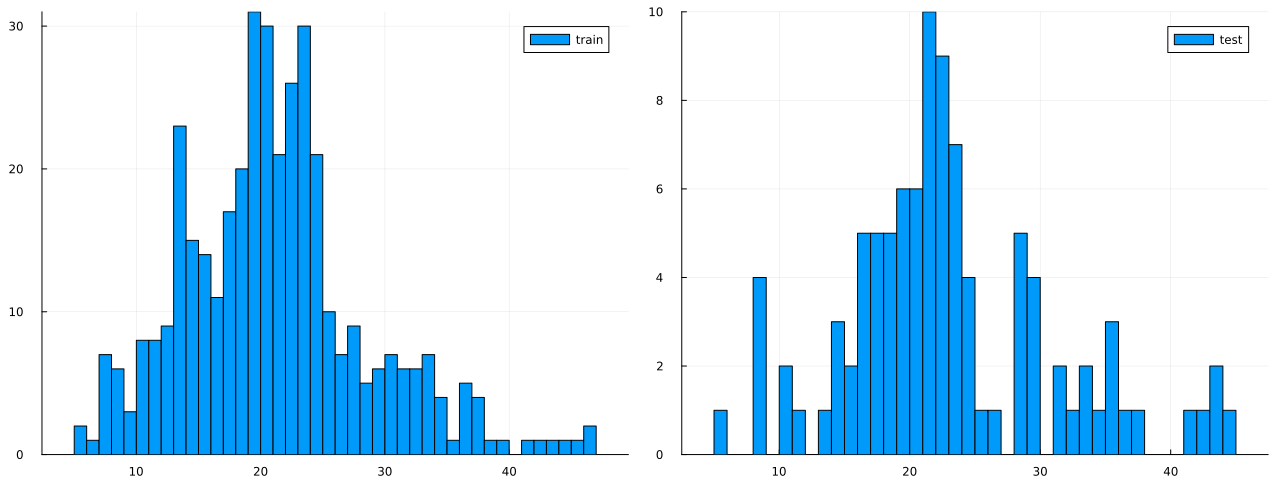

In [26]:
p1 = Plots.histogram(ytrain, label="train", bins=50)
p2 = Plots.histogram(ytest, label="test", bins=50)
plot(p1, p2, layout=(1,2), size= (1280,480),legend=true)

In [29]:
# Assemble all the models to test

SRFE = qsrfe.srfeRegressor(N=1000,σ2=1.0,λ=0.003, intercept=true)
RFE = qsrfe.rfeRegressor(N=1000,σ2=1.0,λ=0.003, intercept=true)

βQ = qsrfe.βQ(K=2,β=1.5,λ=16,condense=true)
;

In [42]:
c = qsrfe.fit(SRFE, xtrain, ytrain,nothing)

MethodError: MethodError: no method matching fit(::Main.qsrfe.srfeRegressor, ::Matrix{Float64}, ::Vector{Float64}, ::Nothing)

Closest candidates are:
  fit(!Matched::Main.qsrfe.rfeRegressor, ::AbstractMatrix{<:Real}, ::AbstractVector{<:Real}, ::Union{Nothing, Main.qsrfe.Quantizer}; verbose)
   @ Main.qsrfe c:\Users\grsbe\Desktop\qsrfe\src\model.jl:55
  fit(!Matched::Main.qsrfe.srfeRegressor, ::AbstractMatrix{<:Real}, ::AbstractVector{<:Real}, ::Union{Nothing, Main.qsrfe.Quantizer}; max_iter, verbose)
   @ Main.qsrfe c:\Users\grsbe\Desktop\qsrfe\src\model.jl:29
  fit(!Matched::Main.qsrfe.rfeRegressor, ::AbstractMatrix{<:Real}, ::AbstractVector{<:Real}; ...)
   @ Main.qsrfe c:\Users\grsbe\Desktop\qsrfe\src\model.jl:55
  ...


In [50]:
function test(y=1,x::Union{Nothing,Int64}=nothing)
    if !isnothing(x)
        return x+y
    end
    return y
end

test (generic function with 8 methods)

In [53]:
remove(test)

UndefVarError: UndefVarError: `remove` not defined

In [51]:
test(2)

MethodError: MethodError: test(::Int64, ::Int64) is ambiguous.

Candidates:
  test(x::Union{Nothing, Int64}, y)
    @ Main c:\Users\grsbe\Desktop\qsrfe\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:1
  test(y, x::Union{Nothing, Int64})
    @ Main c:\Users\grsbe\Desktop\qsrfe\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:1

Possible fix, define
  test(::Union{Nothing, Int64}, ::Union{Nothing, Int64})
